destirbution

50000

all


🔍 Trial 1/15 → {'layers': [384, 256, 128], 'drop': 0.1, 'lr': 0.0005}
   Epoch 01  val-F1=0.5444
   Epoch 02  val-F1=0.5558
   Epoch 03  val-F1=0.5518
   Epoch 04  val-F1=0.5489
   Epoch 05  val-F1=0.5471
   Epoch 06  val-F1=0.5442

🔍 Trial 2/15 → {'layers': [384, 256, 128], 'drop': 0.2, 'lr': 0.001}
   Epoch 01  val-F1=0.5405
   Epoch 02  val-F1=0.5421
   Epoch 03  val-F1=0.5405
   Epoch 04  val-F1=0.5510
   Epoch 05  val-F1=0.5408
   Epoch 06  val-F1=0.5532
   Epoch 07  val-F1=0.5547
   Epoch 08  val-F1=0.5420
   Epoch 09  val-F1=0.5470
   Epoch 10  val-F1=0.5475
   Epoch 11  val-F1=0.5448

🔍 Trial 3/15 → {'layers': [256, 128], 'drop': 0.2, 'lr': 0.0003}
   Epoch 01  val-F1=0.5166
   Epoch 02  val-F1=0.5348
   Epoch 03  val-F1=0.5423
   Epoch 04  val-F1=0.5432
   Epoch 05  val-F1=0.5473
   Epoch 06  val-F1=0.5468
   Epoch 07  val-F1=0.5468
   Epoch 08  val-F1=0.5485
   Epoch 09  val-F1=0.5500
   Epoch 10  val-F1=0.5489
   Epoch 11  val-F1=0.5486
   Epoch 12  val-F1=0.5484
   Epoch 1

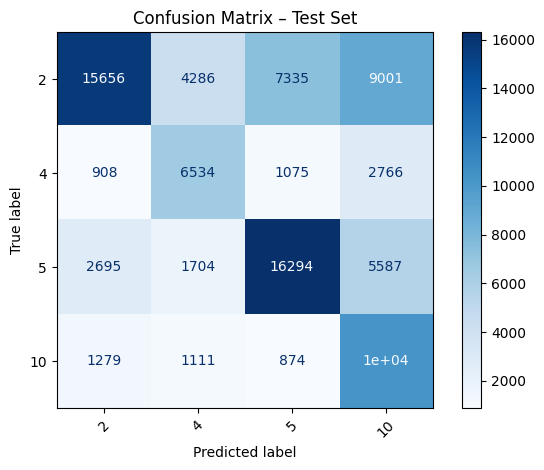

In [ ]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  Tabular Categorical Classifier – Deep Dense Search (Colab Ready) ║
# ╚═══════════════════════════════════════════════════════════════════╝
!pip install -q scikit-learn imbalanced-learn torch

# ─── Imports ────────────────────────────────────────────────────────
import pandas as pd, numpy as np, random, torch, torch.nn as nn, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.utils import resample
from torch.utils.data import Dataset, DataLoader
from collections import Counter

# ─── Global config ─────────────────────────────────────────────────
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

CSV_PATH   = "/content/modified_tedsa_data_clean.csv"
TARGET_COL = "SUB1"          # label

# ─── 1 ▸ Load & optional feature drop ──────────────────────────────
df = pd.read_csv(CSV_PATH)
assert TARGET_COL in df.columns, f"{TARGET_COL} missing"

FEATURES_TO_DROP = []        # ← add weak columns after PFI run if desired
df = df.drop(columns=FEATURES_TO_DROP)

# ─── 2 ▸ Encode label + categorical features ───────────────────────
y_le = LabelEncoder()
y    = y_le.fit_transform(df[TARGET_COL])
X    = df.drop(columns=[TARGET_COL])

enc_dict, X_enc = {}, X.copy()
for col in X_enc.columns:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(X_enc[col].astype(str))
    enc_dict[col] = le
cat_dims = [len(le.classes_) for le in enc_dict.values()]

# ─── 3 ▸ 60/20/20 split (stratified) ───────────────────────────────
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X_enc, y, test_size=0.20, stratify=y, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.25, stratify=y_tmp, random_state=SEED
)

# ─── 4 ▸ Oversample train for balance ──────────────────────────────
def oversample(Xd, yd):
    df_ = pd.concat([Xd.reset_index(drop=True), pd.Series(yd, name="label")], axis=1)
    n_max = df_.label.value_counts().max()
    return pd.concat([
        resample(df_[df_.label == c], replace=True, n_samples=n_max, random_state=SEED)
        for c in df_.label.unique()
    ])
train_os = oversample(X_train, y_train)
X_train_os, y_train_os = train_os.drop(columns='label'), train_os.label

# ─── 5 ▸ PyTorch loaders ───────────────────────────────────────────
class CatDataset(Dataset):
    def __init__(self, Xd, yd):
        self.X = torch.tensor(Xd.values, dtype=torch.long)
        self.y = torch.tensor(np.array(yd), dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

BATCH = 512
train_loader = DataLoader(CatDataset(X_train_os, y_train_os), batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(CatDataset(X_val,      y_val),      batch_size=BATCH)
test_loader  = DataLoader(CatDataset(X_test,     y_test),     batch_size=BATCH)

# ─── 6 ▸ Class weights for CE loss ─────────────────────────────────
cnts = Counter(y_train_os)
tot  = sum(cnts.values())
class_w = torch.tensor([tot/(len(cnts)*cnts[i]) for i in range(len(cnts))], dtype=torch.float32)

# ─── 7 ▸ Model factory (variable depth) ────────────────────────────
class DeepEmbedNet(nn.Module):
    def __init__(self, cat_dims, out_dim, hidden_layers, drop):
        super().__init__()
        emb_dims   = [min(64, (d+1)//2) for d in cat_dims]
        self.embs  = nn.ModuleList([nn.Embedding(d, e) for d, e in zip(cat_dims, emb_dims)])
        self.bn    = nn.BatchNorm1d(sum(emb_dims))
        self.dp_in = nn.Dropout(drop)

        layers, last_dim = [], sum(emb_dims)
        for h in hidden_layers:
            layers.extend([nn.Linear(last_dim, h), nn.ReLU(), nn.Dropout(drop)])
            last_dim = h
        layers.append(nn.Linear(last_dim, out_dim))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        z = torch.cat([e(x[:, i]) for i, e in enumerate(self.embs)], 1)
        z = self.dp_in(self.bn(z))
        return self.mlp(z)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── 8 ▸ Hyper-parameter grid (depth + width) ──────────────────────
grid = [
    # depth = 2 layers
    {"layers": [256, 128],     "drop": d, "lr": lr}
    for d in [0.1, 0.2] for lr in [1e-3, 5e-4, 3e-4]
] + [
    # depth = 3 layers
    {"layers": [384, 256, 128], "drop": d, "lr": lr}
    for d in [0.1, 0.2] for lr in [1e-3, 5e-4, 3e-4]
] + [
    # depth = 4 layers (wide → narrow)
    {"layers": [512, 384, 256, 128], "drop": d, "lr": lr}
    for d in [0.1, 0.2] for lr in [5e-4, 3e-4]
]

random.shuffle(grid)
grid = grid[:15]   # limit runtime; increase if GPU time allows

# ─── 9 ▸ Search loop ───────────────────────────────────────────────
best_f1, best_cfg, best_state = -1, None, None
for ti, cfg in enumerate(grid, 1):
    print(f"\n🔍 Trial {ti}/{len(grid)} → {cfg}")
    net = DeepEmbedNet(cat_dims, len(y_le.classes_), cfg["layers"], cfg["drop"]).to(device)
    loss_fn = nn.CrossEntropyLoss(weight=class_w.to(device))
    opt     = torch.optim.AdamW(net.parameters(), lr=cfg["lr"])
    sched   = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)

    best_val, patience = -1, 0
    for epoch in range(40):
        net.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); loss_fn(net(xb), yb).backward(); opt.step()
        sched.step()

        # validation macro-F1
        net.eval(); preds, true = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds.extend(net(xb).argmax(1).cpu()); true.extend(yb.cpu())
        f1 = f1_score(true, preds, average='macro')
        print(f"   Epoch {epoch+1:02d}  val-F1={f1:.4f}")

        if f1 > best_val: best_val, patience, best_local = f1, 0, net.state_dict()
        else: patience += 1
        if patience >= 4: break  # early stopping

    if best_val > best_f1:
        best_f1, best_cfg, best_state = best_val, cfg, best_local

print("\n✅ Best config:", best_cfg)
print(f"🏆 Best validation macro-F1: {best_f1:.4f}")

# ─── 10 ▸ Final model & Test evaluation ────────────────────────────
model = DeepEmbedNet(cat_dims, len(y_le.classes_), best_cfg["layers"], best_cfg["drop"]).to(device)
model.load_state_dict(best_state); model.eval()

preds, true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds.extend(model(xb).argmax(1).cpu()); true.extend(yb.cpu())

y_true = y_le.inverse_transform(true)
y_pred = y_le.inverse_transform(preds)

print("\n📋 Test classification report:\n",
      classification_report(y_true, y_pred, zero_division=0))
print(f"🎯 Test accuracy: {accuracy_score(y_true, y_pred):.4f}")

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, cmap='Blues', xticks_rotation=45
).ax_.set_title("Confusion Matrix – Test Set")
plt.tight_layout(); plt.show()


Epoch 01  val-F1=0.5393
Epoch 02  val-F1=0.5529
Epoch 03  val-F1=0.5514
Epoch 04  val-F1=0.5466
Epoch 05  val-F1=0.5459
Epoch 06  val-F1=0.5452


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


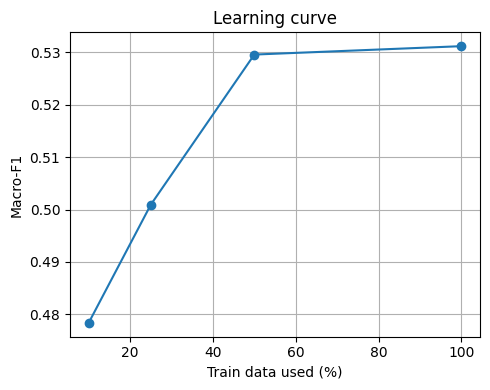


=== Summary ===
                 Model  Macro-F1  Accuracy
0        Embedding MLP  0.545242  0.551276
2  Logistic Regression  0.525409  0.531397
1        Random Forest  0.521196  0.538691 

▶ Saved detailed report to /content/NN_full_report.csv


In [ ]:
# ╔══════════════════════════════════════════════════════════════════╗
# ║  TEDSA-2020  ·  Embedding-MLP vs. Classical Baselines (Full run) ║
# ╚══════════════════════════════════════════════════════════════════╝
!pip install -q scikit-learn imbalanced-learn torch

# ── Imports ────────────────────────────────────────────────────────
import pandas as pd, numpy as np, random, torch, torch.nn as nn, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from torch.utils.data import Dataset, DataLoader
from collections import Counter, defaultdict
from pathlib import Path

# ── Reproducibility ────────────────────────────────────────────────
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

CSV_PATH   = "/content/modified_tedsa_data_clean.csv"
TARGET_COL = "SUB1"

# ── 1 ▸ Load & encode ──────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)
y_le = LabelEncoder();   y = y_le.fit_transform(df[TARGET_COL])
X    = df.drop(columns=[TARGET_COL])

enc_dict, X_enc = {}, X.copy()
for c in X_enc.columns:
    le = LabelEncoder(); X_enc[c] = le.fit_transform(X_enc[c].astype(str)); enc_dict[c] = le
cat_dims = [len(le.classes_) for le in enc_dict.values()]

# ── 2 ▸ 60/20/20 split + oversample train ──────────────────────────
X_tmp, X_test, y_tmp, y_test = train_test_split(X_enc, y, test_size=0.20,
                                                stratify=y, random_state=SEED)
X_train, X_val,  y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25,
                                                   stratify=y_tmp, random_state=SEED)

def oversample(Xd, yd):
    df_ = pd.concat([Xd.reset_index(drop=True), pd.Series(yd, name="y")], axis=1)
    m   = df_.y.value_counts().max()
    return pd.concat([resample(df_[df_.y==c], replace=True, n_samples=m, random_state=SEED)
                      for c in df_.y.unique()])

train_os  = oversample(X_train, y_train)
X_train_os, y_train_os = train_os.drop(columns="y"), train_os.y

# ── 3 ▸ PyTorch dataset / loader ───────────────────────────────────
class CatDS(Dataset):
    def __init__(self, Xd, yd):
        self.X = torch.tensor(Xd.values, dtype=torch.long)
        self.y = torch.tensor(np.array(yd), dtype=torch.long)  # ← fix here
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

BATCH=512
train_loader = DataLoader(CatDS(X_train_os,y_train_os),batch_size=BATCH,shuffle=True)
val_loader   = DataLoader(CatDS(X_val,y_val),batch_size=BATCH)
test_loader  = DataLoader(CatDS(X_test,y_test),batch_size=BATCH)

# ── 4 ▸ Weighted CE loss weights ───────────────────────────────────
cnts = Counter(y_train_os); tot = sum(cnts.values())
class_w = torch.tensor([tot/(len(cnts)*cnts[i]) for i in range(len(cnts))],dtype=torch.float32)

# ── 5 ▸ Deep embedding-MLP (best config fixed) ─────────────────────
class DeepNet(nn.Module):
    def __init__(self,cat,out_dim,layers,drop):
        super().__init__()
        emb = [min(64,(d+1)//2) for d in cat]
        self.emb = nn.ModuleList([nn.Embedding(d,e) for d,e in zip(cat,emb)])
        self.bn  = nn.BatchNorm1d(sum(emb)); self.dp = nn.Dropout(drop)
        seq, dim = [], sum(emb)
        for h in layers:
            seq.extend([nn.Linear(dim,h),nn.ReLU(),nn.Dropout(drop)]); dim=h
        seq.append(nn.Linear(dim,out_dim)); self.mlp = nn.Sequential(*seq)
    def forward(self,x):
        z = torch.cat([e(x[:,i]) for i,e in enumerate(self.emb)],1)
        return self.mlp(self.dp(self.bn(z)))

best_cfg = {'layers':[384,256,128],'drop':0.1,'lr':3e-4}
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net      = DeepNet(cat_dims,len(y_le.classes_),best_cfg['layers'],best_cfg['drop']).to(device)
opt      = torch.optim.AdamW(net.parameters(),lr=best_cfg['lr'])
sched    = torch.optim.lr_scheduler.CosineAnnealingLR(opt,T_max=20)
loss_fn  = nn.CrossEntropyLoss(weight=class_w.to(device))

best_val,best_state = -1,None
for epoch in range(40):
    net.train()
    for xb,yb in train_loader:
        xb,yb = xb.to(device),yb.to(device)
        opt.zero_grad(); loss_fn(net(xb), yb).backward(); opt.step()
    sched.step()
    net.eval(); p,t = [],[]
    with torch.no_grad():
        for xb,yb in val_loader:
            xb,yb=xb.to(device),yb.to(device)
            p.extend(net(xb).argmax(1).cpu()); t.extend(yb.cpu())
    f1 = f1_score(t,p,average='macro')
    if f1>best_val: best_val,best_state = f1,net.state_dict()
    print(f"Epoch {epoch+1:02d}  val-F1={f1:.4f}")
    if epoch-best_val>=4: break

net.load_state_dict(best_state); net.eval()

# ── 6 ▸ Evaluate on test ───────────────────────────────────────────
def torch_predict(loader,model):
    pr,tr=[],[]
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb=xb.to(device), yb.to(device)
            pr.extend(model(xb).argmax(1).cpu()); tr.extend(yb.cpu())
    return np.array(pr), np.array(tr)

pred_nn, true_nn = torch_predict(test_loader, net)
macro_nn = f1_score(true_nn, pred_nn, average='macro')

# ── 7 ▸ Baseline 1: Logistic Regression ────────────────────────────
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)  # ← changed
X_train_ohe = ohe.fit_transform(X_train_os)
X_test_ohe  = ohe.transform(X_test)

logreg = LogisticRegression(
    multi_class="multinomial", solver="lbfgs",
    max_iter=1000, n_jobs=-1, random_state=SEED
)
logreg.fit(X_train_ohe, y_train_os)
pred_lr  = logreg.predict(X_test_ohe)
macro_lr = f1_score(y_test, pred_lr, average="macro")

# ── 8 ▸ Baseline 2: Random Forest ──────────────────────────────────
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, n_jobs=-1, random_state=SEED)
rf.fit(X_train_os, y_train_os)
pred_rf = rf.predict(X_test)
macro_rf = f1_score(y_test, pred_rf, average='macro')

# ── 9 ▸ Learning curve (NN only) ───────────────────────────────────
fractions = [0.1,0.25,0.5,1.0]
curve = []
for frac in fractions:
    m = int(len(X_train_os)*frac)
    samp_idx = np.random.choice(len(X_train_os), m, replace=False)
    Xs,ys = X_train_os.iloc[samp_idx], y_train_os.iloc[samp_idx]
    loader = DataLoader(CatDS(Xs,ys),batch_size=BATCH,shuffle=True)
    net_small = DeepNet(cat_dims,len(y_le.classes_),best_cfg['layers'],best_cfg['drop']).to(device)
    opt_small= torch.optim.AdamW(net_small.parameters(),lr=best_cfg['lr'])
    net_small.train()
    for xb,yb in loader:               # 1 quick epoch
        xb,yb=xb.to(device), yb.to(device)
        opt_small.zero_grad(); loss_fn(net_small(xb), yb).backward(); opt_small.step()
    net_small.eval()
    p,_ = torch_predict(test_loader,net_small)
    curve.append(f1_score(true_nn, p, average='macro'))

plt.figure(figsize=(5,4))
plt.plot(np.array(fractions)*100, curve,'o-')
plt.xlabel("Train data used (%)"); plt.ylabel("Macro-F1"); plt.title("Learning curve")
plt.grid(); plt.tight_layout(); plt.show()

# ── 10 ▸ Tabulate results ─────────────────────────────────────────–
results_df = pd.DataFrame({
    "Model":["Embedding MLP","Random Forest","Logistic Regression"],
    "Macro-F1":[macro_nn, macro_rf, macro_lr],
    "Accuracy":[accuracy_score(true_nn,pred_nn),
                accuracy_score(y_test,pred_rf),
                accuracy_score(y_test,pred_lr)]
}).sort_values("Macro-F1", ascending=False)
print("\n=== Summary ==="); print(results_df, "\n")

# Save full classification report (neural net) for appendix
report_nn = classification_report(true_nn, pred_nn, target_names=y_le.classes_.astype(str), output_dict=True, zero_division=0)
pd.DataFrame(report_nn).T.to_csv("/content/NN_full_report.csv")
print("▶ Saved detailed report to /content/NN_full_report.csv")


In [ ]:
from copy import deepcopy
from sklearn.metrics import f1_score

# Reuse: X_val, y_val, model, label_encoder, val_loader already exist

# 🔁 Prepare for permutation
X_val_copy = X_val.copy()
baseline_preds = []

# Get baseline predictions
model.eval()
with torch.no_grad():
    val_dataset = CatDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=256)
    for xb, _ in val_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().tolist()
        baseline_preds.extend(preds)

baseline_f1 = f1_score(y_val, baseline_preds, average="macro")
print(f"🎯 Baseline macro-F1: {baseline_f1:.4f}")

# 🔍 Permutation importance
feature_importance = {}

for col in X_val.columns:
    X_shuffled = X_val_copy.copy()
    X_shuffled[col] = np.random.permutation(X_shuffled[col].values)

    shuffled_preds = []
    model.eval()
    with torch.no_grad():
        loader = DataLoader(CatDataset(X_shuffled, y_val), batch_size=256)
        for xb, _ in loader:
            xb = xb.to(device)
            preds = model(xb).argmax(1).cpu().tolist()
            shuffled_preds.extend(preds)

    f1_score_shuffled = f1_score(y_val, shuffled_preds, average="macro")
    drop = baseline_f1 - f1_score_shuffled
    feature_importance[col] = drop
    print(f"📉 {col}: Δmacro-F1 = {drop:.4f}")

# 🔽 Sort and display
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("\n📊 Feature Importance (by F1 drop):")
for feature, drop in sorted_importance:
    print(f"{feature:<10} Δmacro-F1: {drop:.4f}")


🎯 Baseline macro-F1: 0.5350
📉 AGE: Δmacro-F1 = 0.1190
📉 GENDER: Δmacro-F1 = 0.0030
📉 RACE: Δmacro-F1 = 0.0465
📉 ETHNIC: Δmacro-F1 = 0.0085
📉 EDUC: Δmacro-F1 = 0.0133
📉 EMPLOY: Δmacro-F1 = 0.0116
📉 LIVARAG: Δmacro-F1 = 0.0095
📉 PRIMINC: Δmacro-F1 = 0.0037
📉 STFIPS: Δmacro-F1 = 0.0725
📉 REGION: Δmacro-F1 = 0.0023
📉 DIVISION: Δmacro-F1 = 0.0073
📉 HLTHINS: Δmacro-F1 = 0.0100

📊 Feature Importance (by F1 drop):
AGE        Δmacro-F1: 0.1190
STFIPS     Δmacro-F1: 0.0725
RACE       Δmacro-F1: 0.0465
EDUC       Δmacro-F1: 0.0133
EMPLOY     Δmacro-F1: 0.0116
HLTHINS    Δmacro-F1: 0.0100
LIVARAG    Δmacro-F1: 0.0095
ETHNIC     Δmacro-F1: 0.0085
DIVISION   Δmacro-F1: 0.0073
PRIMINC    Δmacro-F1: 0.0037
GENDER     Δmacro-F1: 0.0030
REGION     Δmacro-F1: 0.0023
